In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.cm as cm

import scipy
import scipy.cluster.hierarchy as sch
import time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

from IPython.core.display import display, HTML
from datetime import datetime, timedelta

pd.set_option('display.float_format', '{:.5g}'.format)

def getKey(item):
    return item[0]


def addAtt(data,key,value):
    data[key] = value
    return data

In [2]:
nameFile = 'datos0823.csv'
freqGlobal = "15min"
nameExperiment = nameFile.split('.')[0]
modWriteFileExp = 'w'
#modWriteFileExp = 'a'

In [3]:
def my_test(date, time):
    strTest = str(time)[:-2]
    testLen=len(strTest)
    t = str(date)[:-2]+(6-(testLen))*'0'+strTest
    return t[:4]+'-'+t[4:6]+'-'+t[6:8]+' '+t[8:10]+':'+t[10:12]+':'+t[12:14]

def getDataToProcess(fileDir):
    dataOut = pd.read_csv(fileDir,
                     delimiter=';',
                     decimal='.')
    df = dataOut[['<DATE>','<TIME>','<CLOSE>']]

    df['time'] = df.apply(lambda row: my_test(row['<DATE>'], row['<TIME>']), axis=1)
    del df['<DATE>'] 
    del df['<TIME>']
    #print(df)
    
    #df = df.drop(df.index[[0]])
    df['price'] = pd.to_numeric(df['<CLOSE>'], downcast='float')
    del df['<CLOSE>']
    df.index = pd.to_datetime(df['time'])
    del df['time']
    return df

In [4]:
def fillData(dataOut):
    data = []
    dfDays = dataOut.groupby(pd.Grouper(freq='D'))
    global freqGlobal
    for dateD,groupD in dfDays:
        if(groupD.shape[0] > 0):
            init = groupD.head(1).index[0]
            end = groupD.tail(1).index[0]
            if(init.weekday() <= 4):
                dates = pd.date_range(init, end, freq=freqGlobal)
                
                dfTem = pd.DataFrame(index=dates, columns=['price'])
                dfTem['price'] = groupD['price']
                dfTem=dfTem.fillna(method='ffill').fillna(method='bfill')
                data.append(dfTem)
    df=pd.concat(data)
    return df

In [5]:
dirr = 'datosMuestra/'+nameFile
dataProcess1 = getDataToProcess(dirr)
df1 = fillData(dataProcess1)

In [6]:
print(df1.head(2))
print(df1.tail(2))

                     price
2019-01-02 04:15:00  54.31
2019-01-02 04:30:00  54.22
                     price
2019-08-23 23:30:00  59.12
2019-08-23 23:45:00   59.1


In [7]:
df1.shape

(15742, 1)

In [8]:
#groups=['6M','4M','3M','2M','1M','3W']

In [9]:
#file = open("datosMuestraFiltrados/index.txt","w") 
#for g in groups:
#    dfGroup = df1.groupby(pd.Grouper(freq=g))
#    lenGroup=str(len(dfGroup.size()))
#    for i,(dateD,groupD) in enumerate(dfGroup):
#        limit=int(groupD.shape[0]*float(0.7))
#        train = groupD.iloc[:limit]
#        test = groupD.iloc[limit:]
#        train.to_csv('datosMuestraFiltrados/train_'+g+'_'+str(i)+'_'+lenGroup+'.csv', sep='\t', header=None)
#        test.to_csv('datosMuestraFiltrados/test_'+g+'_'+str(i)+'_'+lenGroup+'.csv', sep='\t', header=None)
#        file.write('_'+g+'_'+str(i)+'_'+lenGroup+'\n')
#file.close() 

In [10]:
#groups=[['1M',4,2],['1M',3,1],['1M',2,1],['1W',5,3],['1W',6,2],['1W',3,1],['1W',2,1]]
#['1D',5,3],['1D',5,2],['1D',4,2],['1D',4,3],['1D',3,2],['1D',3,1],['1D',2,1]
#[['1D',5,3],['1D',5,2],['1D',4,2],['1D',4,3],['1D',3,2],['1D',3,1],['1D',2,1]]
groups=[['1D',15,3]]

In [11]:
file = open("datosMuestraFiltrados/index.txt",modWriteFileExp) 
for g in groups:
    dfGroup = df1.groupby(pd.Grouper(freq=g[0]))
    lenGroup=str(len(dfGroup.size()))
    buffer=[]
    buffer2=[]
    for i,(dateD,group) in enumerate(dfGroup):
        buffer.append(group)
        buffer2.append(i)
        if(len(buffer) >= g[1]+g[2]):
            print()
            print(buffer2[:g[1]])
            print(buffer2[g[1]:])
            
            
            train=pd.concat(buffer[:g[1]])
            test=pd.concat(buffer[g[1]:])
            
            if(test.shape[0]>0 and train.shape[0]>0):
                print(buffer2[:g[1]])
                print(buffer2[g[1]:])
                print(g)    
                print(train.shape)
                print(test.shape)
                cred = g[0]+'_'+str(g[1])+'_'+str(g[2])
                name = '_'+cred+'_'+str(i)+'_'+lenGroup+'_'+nameExperiment
                train.to_csv('datosMuestraFiltrados/train'+name+'.csv', sep='\t', header=None)
                test.to_csv('datosMuestraFiltrados/test'+name+'.csv', sep='\t', header=None)
                file.write(name+'\n')
            del buffer[0]
            del buffer2[0]
file.close() 


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17]
['1D', 15, 3]
(1021, 1)
(192, 1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18]
['1D', 15, 3]
(1038, 1)
(96, 1)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[17, 18, 19]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[17, 18, 19]
['1D', 15, 3]
(1038, 1)
(76, 1)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[18, 19, 20]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[18, 19, 20]
['1D', 15, 3]
(942, 1)
(155, 1)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[19, 20, 21]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[19, 20, 21]
['1D', 15, 3]
(942, 1)
(251, 1)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22]
['1D', 15, 3]
(1018, 1)
(271, 1)

[

[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[61, 62, 63]
['1D', 15, 3]
(907, 1)
(279, 1)

[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[62, 63, 64]
[47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
[62, 63, 64]
['1D', 15, 3]
(994, 1)
(288, 1)

[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[63, 64, 65]
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[63, 64, 65]
['1D', 15, 3]
(1021, 1)
(288, 1)

[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
[64, 65, 66]
[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
[64, 65, 66]
['1D', 15, 3]
(1038, 1)
(192, 1)

[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
[65, 66, 67]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
[65, 66, 67]
['1D', 15, 3]
(1038, 1)
(96, 1)

[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[66, 67, 68]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
[66, 67, 68]
['1D', 15, 3]
(1038


[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
[108, 109, 110]
[93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107]
[108, 109, 110]
['1D', 15, 3]
(951, 1)
(91, 1)

[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
[109, 110, 111]
[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
[109, 110, 111]
['1D', 15, 3]
(855, 1)
(187, 1)

[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[110, 111, 112]
[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[110, 111, 112]
['1D', 15, 3]
(855, 1)
(283, 1)

[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
[111, 112, 113]
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
[111, 112, 113]
['1D', 15, 3]
(946, 1)
(288, 1)

[97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
[112, 113, 114]
[97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
[112, 113, 114


[135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
[150, 151, 152]
[135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
[150, 151, 152]
['1D', 15, 3]
(1051, 1)
(96, 1)

[136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[151, 152, 153]
[136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[151, 152, 153]
['1D', 15, 3]
(955, 1)
(192, 1)

[137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]
[152, 153, 154]
[137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151]
[152, 153, 154]
['1D', 15, 3]
(955, 1)
(288, 1)

[138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]
[153, 154, 155]
[138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]
[153, 154, 155]
['1D', 15, 3]
(1051, 1)
(288, 1)

[139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153]
[154, 155, 156]
[139, 140, 141, 142, 143, 144, 145, 14


[173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]
[188, 189, 190]
[173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]
[188, 189, 190]
['1D', 15, 3]
(1015, 1)
(288, 1)

[174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]
[189, 190, 191]
[174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188]
[189, 190, 191]
['1D', 15, 3]
(1020, 1)
(288, 1)

[175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
[190, 191, 192]
[175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]
[190, 191, 192]
['1D', 15, 3]
(1020, 1)
(192, 1)

[176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[191, 192, 193]
[176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[191, 192, 193]
['1D', 15, 3]
(1020, 1)
(96, 1)

[177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
[192, 193, 194]
[177, 178, 179, 180, 181, 182, 183, 

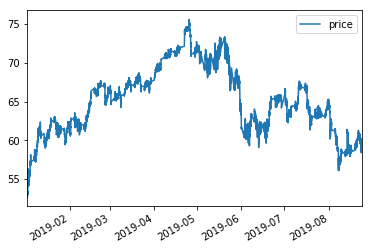

In [12]:
df1.plot()

In [13]:
df1.to_csv('datosParaSimulacion_MTCDocker/data.csv', sep=';',header=None)
df1.head(2)

price
2019-01-02 04:15:00  54.31
2019-01-02 04:30:00  54.22

In [14]:
dfTest=pd.read_csv('datosParaSimulacion_MTCDocker/data.csv',delimiter=';',decimal='.',header=None)
dfTest.index=pd.to_datetime(dfTest[0])
del dfTest[0]
dfTest.head(2)

1
0                        
2019-01-02 04:15:00 54.31
2019-01-02 04:30:00 54.22